ELO ratings normalized between 0 and 1:
[1.         0.91671203 0.92324442 0.90800218 0.94610778 0.91017964
 0.97005988 0.96679369 0.90201415 0.89439303 0.85574306 0.92868808
 0.93522047 0.95155144 0.93739793 0.933043   0.89221557 0.88459445
 0.93739793 0.92106696 0.9156233  0.89275993 0.90364725 0.89874796
 0.84812194 0.95645073 0.90473598 0.8709853  0.73053892 0.90636908
 0.88187262 0.88894937 0.95100708 0.94501905 0.8105607  0.91507893
 0.90419162 0.82362548 0.88078389 0.8726184  0.7849755  0.85846489
 0.74578116 0.94120849 0.79422972 0.89820359 0.88350572 0.85792052
 0.83233533 0.81328253 0.83451279 0.83614589 0.86118672 0.87479586
 0.8535656  0.86445291 0.78170931 0.80239521 0.95209581 0.80239521
 0.84485574 0.79368536 0.80185084 0.67229178 0.61567774 0.76537833
 0.77844311 0.87152967 0.78116494 0.70985302 0.7849755  0.726184
 0.71856287 0.77463255 0.67555797 0.73652695 0.72346217 0.76102341
 0.66303756 0.92106696 0.78007621 0.71039739 0.56069679 0.81709309
 0.69569951 0.7866086  0

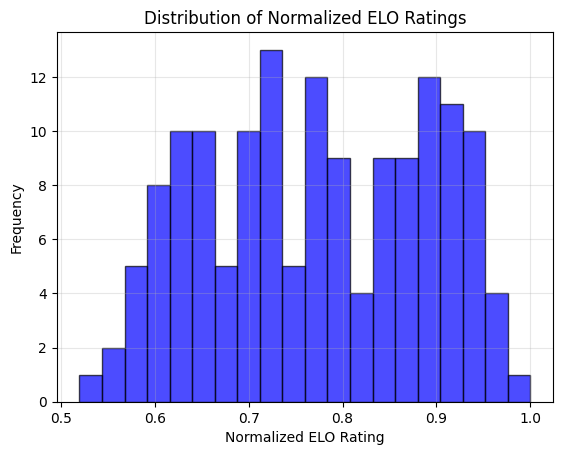

\begin{table}
\caption{Top 10 Players with Normalized ELO Ratings}
\label{tab:top_players}
\begin{tabular}{lrr}
\toprule
Name & Rating (Rtg) & Normalized ELO \\
\midrule
Carlsen  Magnus  & 2837 & 1.000000 \\
Erigaisi Arjun   & 2782 & 0.916712 \\
Caruana  Fabiano  & 2776 & 0.923244 \\
Nepomniachtchi  Ian  & 2757 & 0.908002 \\
Aravindh  Chithambaram VR.  & 2749 & 0.946108 \\
So  Wesley  & 2748 & 0.910180 \\
Aronian  Levon  & 2747 & 0.970060 \\
Dominguez Perez  Leinier  & 2738 & 0.966794 \\
Niemann  Hans Moke  & 2736 & 0.902014 \\
Le  Quang Liem  & 2729 & 0.894393 \\
\bottomrule
\end{tabular}
\end{table}



In [46]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel("chessResultsList.xlsx")

# PRISE EN COMPTE DE TOUTES LES VALEURS
first_row = df.iloc[0].copy()

elos = df["Rtg"].values

# Normalisation des ELOs entre 0 et 1
elos = (elos - 1000) / (elos.max() - 1000)

print("ELO ratings normalized between 0 and 1:")
print(elos)

# Affichage de l'histogramme
plt.hist(elos, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Normalized ELO Ratings')
plt.xlabel('Normalized ELO Rating')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

# Affichage d'un tableau avec les elos des premiers joueurs et leur force correspondante
df.sort_values(by="Rtg", ascending=False, inplace=True)
top_players = df.head(10)[["Name", "Rtg"]].copy()
top_players["Normalized ELO"] = elos[:10]
latex_table = top_players.to_latex(
    index=False,
    header=["Name", "Rating (Rtg)", "Normalized ELO"],
    caption="Top 10 Players with Normalized ELO Ratings",
    label="tab:top_players",
    float_format="%.6f"
)

# Print the LaTeX table
print(latex_table)


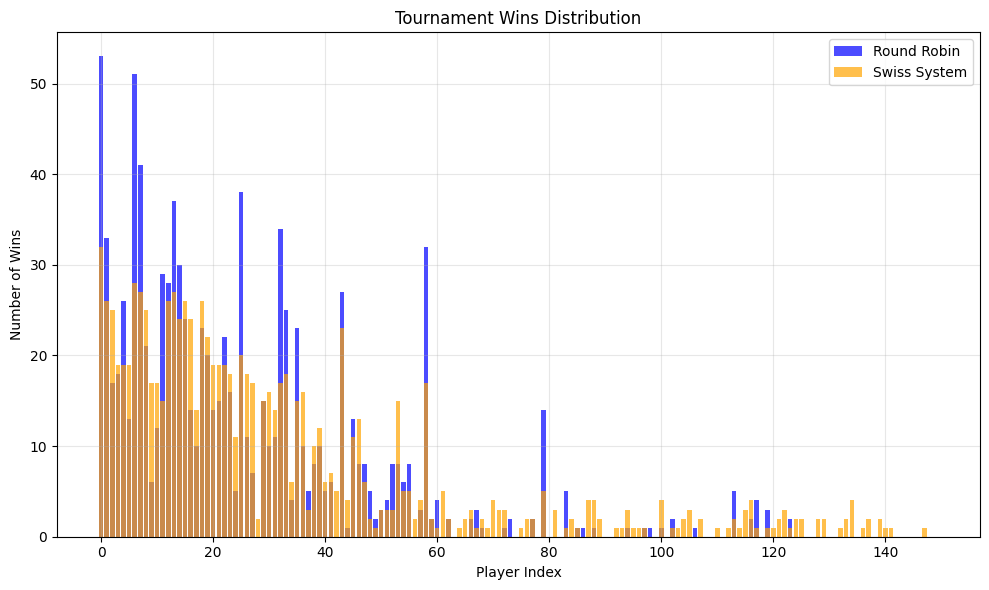

In [47]:
import random

# Function to simulate a match between two players
def simulate_match(player1, player2):
    # Higher ELO gives a higher probability of winning
    probability_player1_wins = player1 / (player1 + player2)
    return random.random() < probability_player1_wins

# Create a round-robin tournament
def round_robin_tournament(elos):
    scores = [0] * len(elos)  # Initialize scores for all players

    # Each player plays against every other player
    for i in range(len(elos)):
        for j in range(i + 1, len(elos)):
            if simulate_match(elos[i], elos[j]):
                scores[i] += 1  # Player i wins
            else:
                scores[j] += 1  # Player j wins

    # The winner is the player with the highest score
    return scores.index(max(scores))

# Create a Swiss-system tournament
def swiss_system_tournament(elos, rounds=9):
    scores = [0] * len(elos)  # Initialize scores for all players
    players = list(range(len(elos)))  # Player indices

    for _ in range(rounds):
        # Sort players by scores (descending) and ELOs (descending) for pairing
        players.sort(key=lambda x: (-scores[x], -elos[x]))
        for i in range(0, len(players), 2):
            if i + 1 < len(players):  # Ensure there is a pair
                player1, player2 = players[i], players[i + 1]
                if simulate_match(elos[player1], elos[player2]):
                    scores[player1] += 1  # Player 1 wins
                else:
                    scores[player2] += 1  # Player 2 wins

    # The winner is the player with the highest score
    return scores.index(max(scores))

# Number of tournaments to simulate
num_tournaments = 1000

# Dictionary to count wins for each player
win_counts_rr = {i: 0 for i in range(len(elos))}
win_counts_sw = {i: 0 for i in range(len(elos))}

# Run the tournaments
for _ in range(num_tournaments):
    winner_rr = round_robin_tournament(elos)
    winner_sw = swiss_system_tournament(elos)
    win_counts_rr[winner_rr] += 1
    win_counts_sw[winner_sw] += 1

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(win_counts_rr.keys(), win_counts_rr.values(), color='blue', alpha=0.7, label='Round Robin')
plt.bar(win_counts_sw.keys(), win_counts_sw.values(), color='orange', alpha=0.7, label='Swiss System')
plt.title('Tournament Wins Distribution')
plt.xlabel('Player Index')
plt.ylabel('Number of Wins')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

ELO rating of Magnus Carlsen normalized between 0 and 1:
1.0308641975308641
ELO ratings normalized between 0 and 1:
[0.94500561 0.95173962 0.93602694 0.97530864 0.9382716  1.
 0.996633   0.9298541  0.92199776 0.88215488 0.95735129 0.9640853
 0.98092031 0.96632997 0.96184063 0.91975309 0.91189675 0.96632997
 0.94949495 0.94388328 0.92031425 0.9315376  0.92648709 0.87429854
 0.98597082 0.93265993 0.89786756 0.75308642 0.93434343 0.90909091
 0.91638608 0.98035915 0.97418631 0.835578   0.94332211 0.93209877
 0.84904602 0.90796857 0.89955107 0.80920314 0.88496072 0.7687991
 0.97025814 0.81874299 0.92592593 0.91077441 0.88439955 0.85802469
 0.83838384 0.86026936 0.86195286 0.88776655 0.90179574 0.87991021
 0.89113356 0.80583614 0.82716049 0.98148148 0.82716049 0.87093154
 0.81818182 0.82659933 0.69304153 0.63468013 0.78900112 0.80246914
 0.89842873 0.80527497 0.73176207 0.80920314 0.74859708 0.74074074
 0.79854097 0.69640853 0.75925926 0.74579125 0.78451178 0.68350168
 0.94949495 0.80415264 

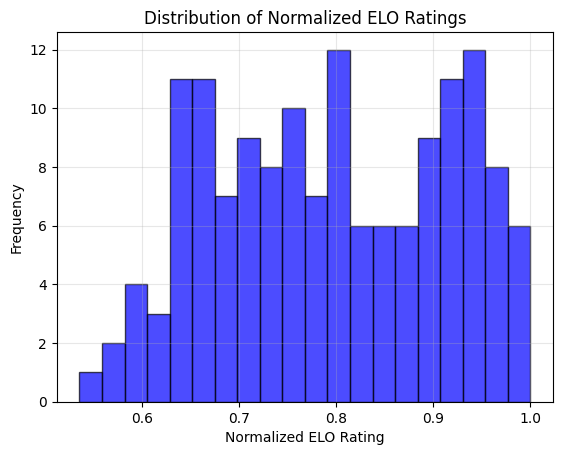

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel("chessResultsList.xlsx")

# Mise à part de la première ligne (Magnus Carlsen)
first_row = df.iloc[0].copy()
df = df.drop(index=0)

elos = df["Rtg"].values

# Affichage de l'ELO du premier joueur normalisé
print("ELO rating of Magnus Carlsen normalized between 0 and 1:")
elo = first_row["Rtg"]
# elo auquel on estime que Magnus Carlsen a joué:
# elo = first_row["Rp"]
elo = (elo-1000) / (elos.max()-1000)
print(elo)

# Normalisation des ELOs entre 0 et 1
elos = (elos - 1000) / (elos.max() - 1000)

print("ELO ratings normalized between 0 and 1:")
print(elos)

# Affichage de l'histogramme
plt.hist(elos, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Normalized ELO Ratings')
plt.xlabel('Normalized ELO Rating')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

# Estimation du paramètre α

Pour une distribution avec une répartition de queue $\ \pi (1-u) \sim  C * u^{α}$, on peut estimer α à l'aide d'une régression linéaire.

En effet, si on prend le logarithme de la répartition de queue, on obtient une relation linéaire entre log(π(1-u)) et log(u) :

$$log( \pi (1-u)) = log(C) - α * log(u)$$

Estimated α: 1.2440
Estimated C: 4.4120
R-squared: 0.9671


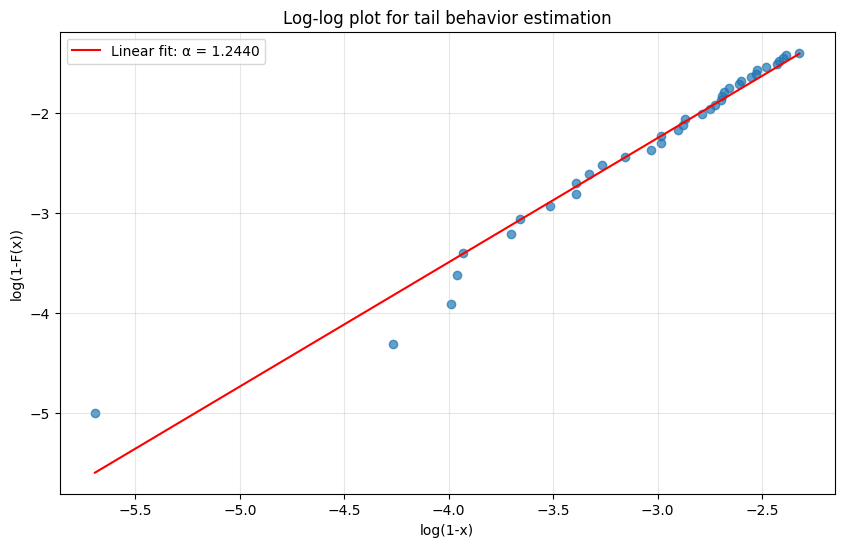

In [49]:
import numpy as np
from scipy import stats

sorted_elos = np.sort(elos)

# Creation de la fonction de répartition empirique
n = len(sorted_elos)
ecdf = np.arange(1, n + 1) / n

# On se concentre sur la queue supérieure de la distribution
# On choisit un seuil de 0.75 pour se concentrer sur le 25% supérieur des valeurs
threshold = 0.75
tail_indices = sorted_elos >= np.quantile(sorted_elos, threshold)

tail_elos = sorted_elos[tail_indices]
tail_ecdf = ecdf[tail_indices]

# Calcul de la fonction de survie
survival = 1 - tail_ecdf

# Calcul de la distance à la valeur maximale
distance_from_max = 1 - tail_elos

# Filtrage des valeurs pour éviter les problèmes de log(0)
valid_indices = (distance_from_max > 0) & (survival > 0)
log_distance = np.log(distance_from_max[valid_indices])
log_survival = np.log(survival[valid_indices])

# Estimation de la relation log-log
slope, intercept, r_value, p_value, std_err = stats.linregress(log_distance, log_survival)

# Affichage des résultats
alpha = slope
C = np.exp(intercept)

print(f"Estimated α: {alpha:.4f}")
print(f"Estimated C: {C:.4f}")
print(f"R-squared: {r_value**2:.4f}")

# Plot the log-log relationship
plt.figure(figsize=(10, 6))
plt.scatter(log_distance, log_survival, alpha=0.7)
plt.plot(log_distance, intercept + slope * log_distance, 'r-', 
         label=f'Linear fit: α = {alpha:.4f}')
plt.title('Log-log plot for tail behavior estimation')
plt.xlabel('log(1-x)')
plt.ylabel('log(1-F(x))')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Verification des conditions du théorème

Théorème:

- Soit $\  \sigma^{2}= E[  \frac {θ}{1+θ^{2}}  ] $ la variance du meilleur joueur.
- Soit $\ ε_n$ = $\ \sqrt{ \frac{2- \alpha } {\sigma^{2}} * \frac {log(n)}{n} } $

Alors:
- Si lim inf $\ [ \frac{θ_n - 1}{ε_n} ]$> 1, alors P(s* wins) → 1
- Si lim sup $\ [ \frac{θ_n - 1}{ε_n} ]$< 1, alors P(s* wins) → 0

Où $\ θ_n $ représente la force du "super" joueur, et $\ ε_n $ est un seuil qui détermine la probabilité de victoire.

Is α < 2? True
σ² = 0.245033
ε_n = 0.321883
θ*_n = 1.030864
(θ*_n - 1)/ε_n = 0.095886

According to the theorem, P(s* wins) → 0
This suggests that even the best player (Magnus Carlsen) will not consistently win.


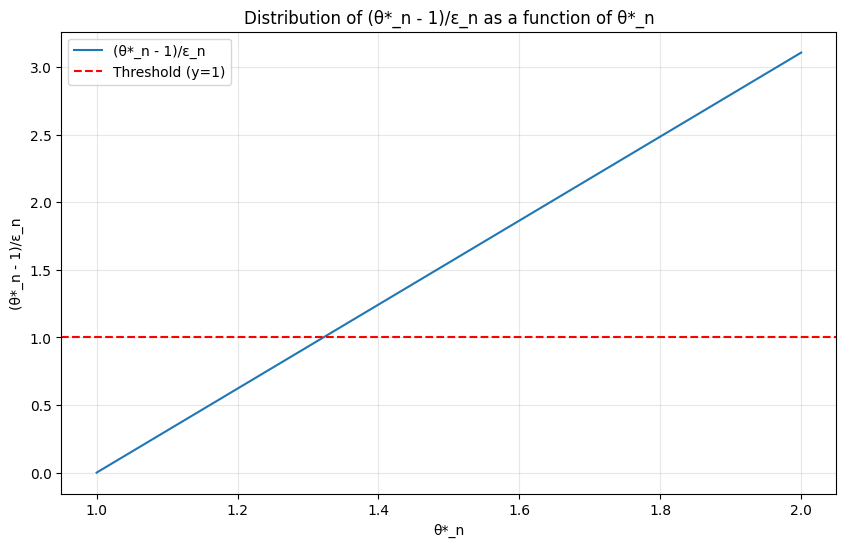

Value of θ*_n for which (θ*_n - 1)/ε_n = 1: 1.321883


In [50]:
# Vérification de la condition α < 2
print(f"Is α < 2? {alpha < 2}")

# Calcul de σ² = E[θ/(1+θ)²]
def variance_term(theta):
    return theta / ((1 + theta) ** 2)

sigma_squared = np.mean(variance_term(sorted_elos))
print(f"σ² = {sigma_squared:.6f}")

# Calcul de ε_n: ε_n = √((2-α)/σ²) * √(log(n)/n)
epsilon_n = np.sqrt((2 - alpha) / sigma_squared) * np.sqrt(np.log(n) / n)
print(f"ε_n = {epsilon_n:.6f}")

# Calcul de (θ*_n - 1)/ε_n
theta_star_n = elo  # puissance de Magnus Carlsen
threshold_ratio = (theta_star_n - 1) / epsilon_n
print(f"θ*_n = {theta_star_n:.6f}")
print(f"(θ*_n - 1)/ε_n = {threshold_ratio:.6f}")

# Interprétation du résultat
if threshold_ratio > 1:
    print("\nAccording to the theorem, P(s* wins) → 1")
    print("This suggests that the best player (Magnus Carlsen) will win with high probability.")
else:
    print("\nAccording to the theorem, P(s* wins) → 0")
    print("This suggests that even the best player (Magnus Carlsen) will not consistently win.")
    
# Affichage de la distribution de (θ*_n - 1)/ε_n en fonction de θ*_n
theta_star_n_values = np.linspace(1, 2, 100)
epsilon_n_values = np.sqrt((2 - alpha) / sigma_squared) * np.sqrt(np.log(n) / n)
plt.figure(figsize=(10, 6))
plt.plot(theta_star_n_values, (theta_star_n_values - 1) / epsilon_n_values, label='(θ*_n - 1)/ε_n')
plt.axhline(y=1, color='r', linestyle='--', label='Threshold (y=1)')
plt.title('Distribution of (θ*_n - 1)/ε_n as a function of θ*_n')
plt.xlabel('θ*_n')
plt.ylabel('(θ*_n - 1)/ε_n')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Retourner la valeur de θ*_n pour laquelle (θ*_n - 1)/ε_n = 1
def find_theta_star_n(target_value=1):
    # Solve for θ*_n such that (θ*_n - 1)/ε_n = target_value
    theta_star_n = target_value * epsilon_n + 1
    return theta_star_n
theta_star_n_value = find_theta_star_n()
print(f"Value of θ*_n for which (θ*_n - 1)/ε_n = 1: {theta_star_n_value:.6f}")

Modification pour permettre des égalités

In [51]:
# Function to simulate a match between two players
def simulate_modif_match(player1, player2,seuil=0.05):
    # Higher ELO gives a higher probability of winning
    probability_player1_wins = player1 / (player1 + player2)
    y=random.random()
    # But there might still be a draw
    if abs(y-probability_player1_wins)<seuil:
        return "Draw"
    elif y < probability_player1_wins:
        return "Victoire"
    else:
        return "Défaite"

# Create a round-robin tournament
def round_robin_modif(elos):
    scores = [0] * len(elos)  # Initialize scores for all players

    # Each player plays against every other player
    for i in range(len(elos)):
        for j in range(i + 1, len(elos)):
            result=simulate_modif_match(elos[i], elos[j])
            if result=="Draw":
                scores[i] += 0.5
                scores[j] += 0.5     
            elif result=="Victoire":
                scores[i] += 1  # Player i wins
            else:
                scores[j] += 1  # Player j wins

    # The winner is the player with the highest score
    return scores.index(max(scores))

# Create a Swiss-system tournament
def swiss_system_modif(elos, rounds=9):
    scores = [0] * len(elos)  # Initialize scores for all players
    players = list(range(len(elos)))  # Player indices

    for _ in range(rounds):
        # Sort players by scores (descending) and ELOs (descending) for pairing
        players.sort(key=lambda x: (-scores[x], -elos[x]))
        for i in range(0, len(players), 2):
            if i + 1 < len(players):  # Ensure there is a pair
                player1, player2 = players[i], players[i + 1]
                result=simulate_modif_match(elos[player1], elos[player2])
                if result=="Draw":
                    scores[player1] += 0.5
                    scores[player2] += 0.5                 
                elif result=="Victoire":
                    scores[player1] += 1  # Player 1 wins
                else:
                    scores[player2] += 1  # Player 2 wins

    # The winner is the player with the highest score
    return scores.index(max(scores))

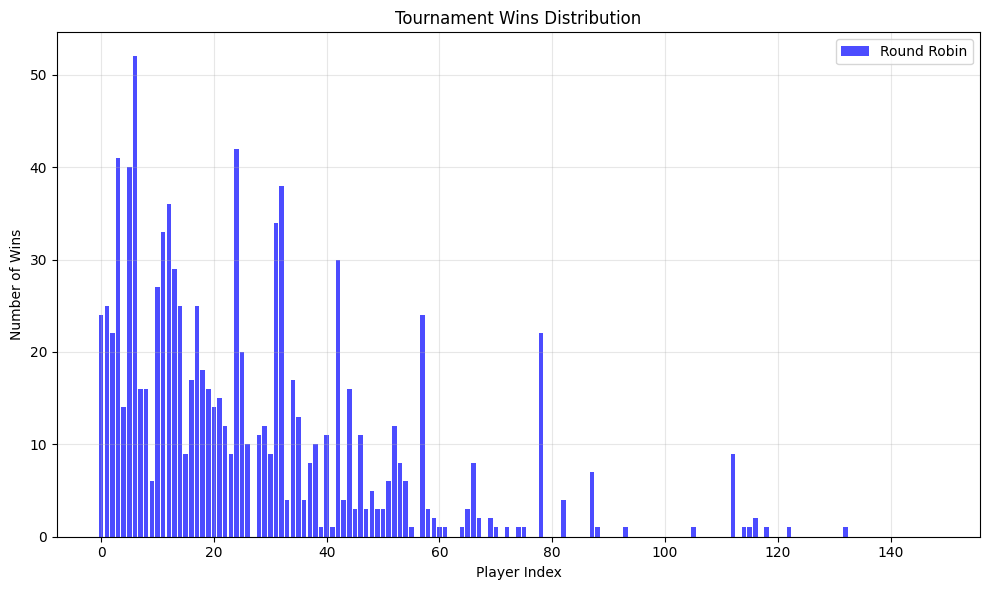

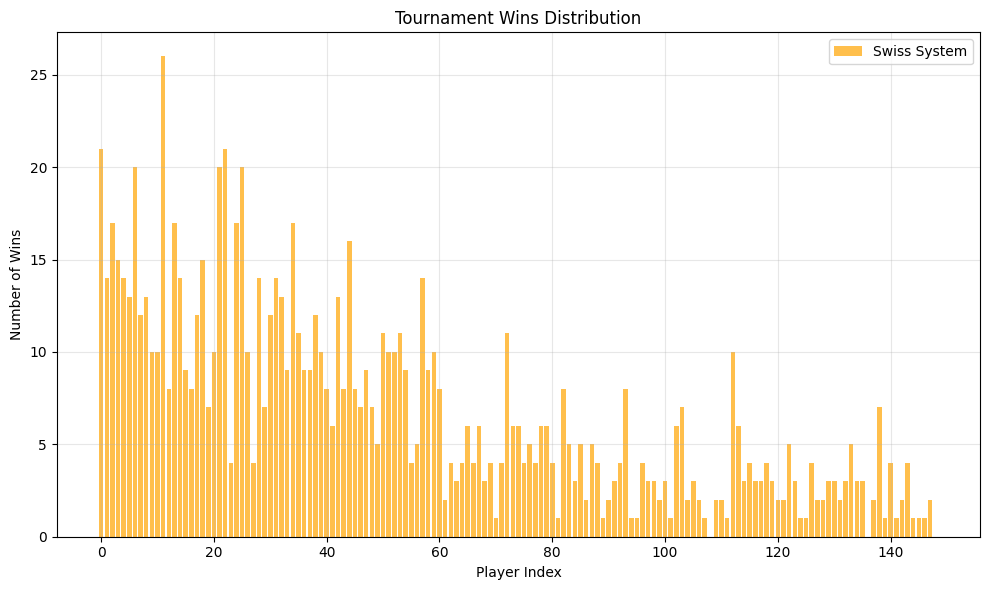

In [ ]:
# Number of tournaments to simulate
num_tournaments = 1000

# Dictionary to count wins for each player
win_counts_rrm = {i: 0 for i in range(len(elos))}
win_counts_swm = {i: 0 for i in range(len(elos))}

# Run the tournaments
for _ in range(num_tournaments):
    winner_rrm = round_robin_modif(elos)
    winner_swm = swiss_system_modif(elos)
    win_counts_rrm[winner_rrm] += 1
    win_counts_swm[winner_swm] += 1

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(win_counts_rrm.keys(), win_counts_rrm.values(), color='blue', alpha=0.7, label='Round Robin')
plt.title('Tournament Wins Distribution')
plt.xlabel('Player Index')
plt.ylabel('Number of Wins')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))
plt.bar(win_counts_swm.keys(), win_counts_swm.values(), color='orange', alpha=0.7, label='Swiss System')
plt.title('Tournament Wins Distribution')
plt.xlabel('Player Index')
plt.ylabel('Number of Wins')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Fonction finale avec des égalités dynamiques

In [78]:
# Function to simulate a match between two players
def simulate_final_match(player1, player2):
    probability_player1_wins = player1 / (player1 + player2)
    y=random.random()
    seuil=0.05*(1-abs(0.5-probability_player1_wins))
    if probability_player1_wins < 0.5: #To see who's the expected winner
        draw_center = probability_player1_wins + seuil * (1/3)
    else:
        draw_center = probability_player1_wins - seuil * (1/3)
    if abs(y-draw_center)<seuil:
        return "Draw"
    elif y < probability_player1_wins:
        return "Victoire"
    else:
        return "Défaite"

# Create a round-robin tournament
def round_robin_final(elos):
    scores = [0] * len(elos)  # Initialize scores for all players

    # Each player plays against every other player
    for i in range(len(elos)):
        for j in range(i + 1, len(elos)):
            result=simulate_final_match(elos[i], elos[j])
            if result=="Draw":
                scores[i] += 0.5
                scores[j] += 0.5     
            elif result=="Victoire":
                scores[i] += 1  # Player i wins
            else:
                scores[j] += 1  # Player j wins

    # The winner is the player with the highest score
    return scores.index(max(scores))

# Create a Swiss-system tournament
def swiss_system_final(elos, rounds=9):
    scores = [0] * len(elos)  # Initialize scores for all players
    players = list(range(len(elos)))  # Player indices

    for _ in range(rounds):
        # Sort players by scores (descending) and ELOs (descending) for pairing
        players.sort(key=lambda x: (-scores[x], -elos[x]))
        for i in range(0, len(players), 2):
            if i + 1 < len(players):  # Ensure there is a pair
                player1, player2 = players[i], players[i + 1]
                result=simulate_final_match(elos[player1], elos[player2])
                if result=="Draw":
                    scores[player1] += 0.5
                    scores[player2] += 0.5                 
                elif result=="Victoire":
                    scores[player1] += 1  # Player 1 wins
                else:
                    scores[player2] += 1  # Player 2 wins

    # The winner is the player with the highest score
    return scores.index(max(scores))

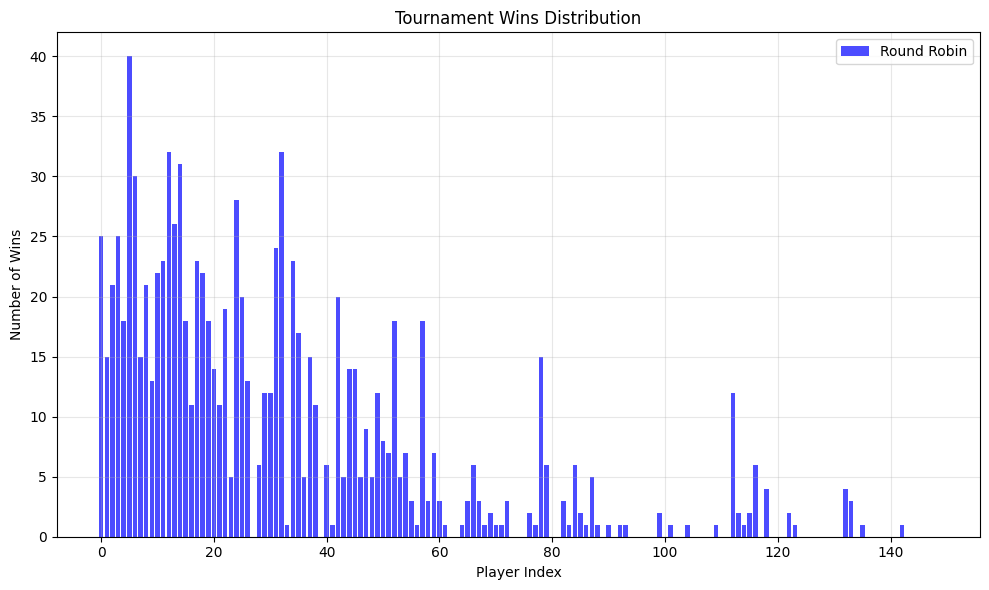

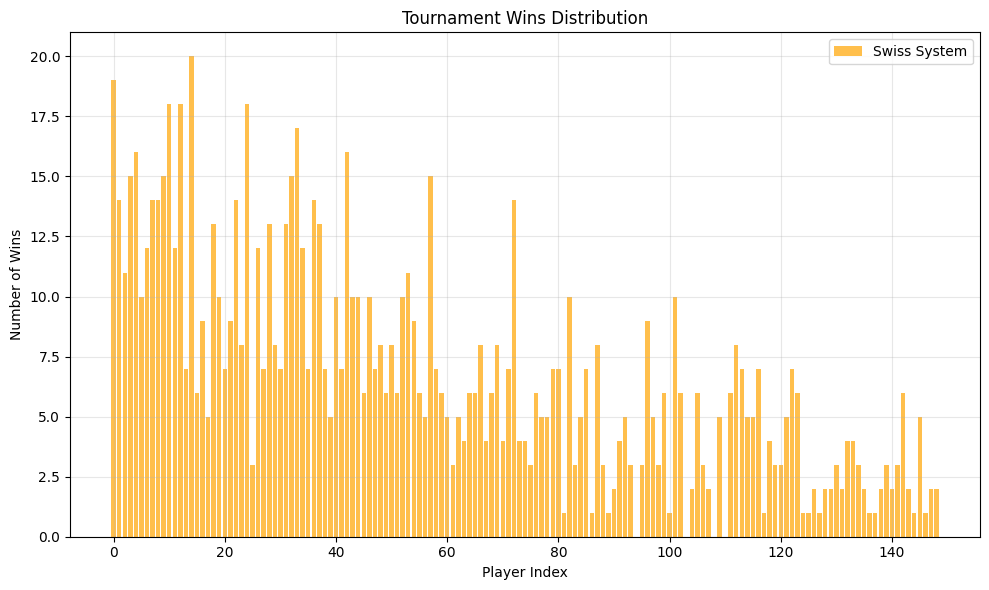

In [79]:
# Number of tournaments to simulate
num_tournaments = 1000

# Dictionary to count wins for each player
win_counts_rrf = {i: 0 for i in range(len(elos))}
win_counts_swf = {i: 0 for i in range(len(elos))}

# Run the tournaments
for _ in range(num_tournaments):
    winner_rrf = round_robin_final(elos)
    winner_swf = swiss_system_final(elos)
    win_counts_rrf[winner_rrf] += 1
    win_counts_swf[winner_swf] += 1

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(win_counts_rrf.keys(), win_counts_rrf.values(), color='blue', alpha=0.7, label='Round Robin')
plt.title('Tournament Wins Distribution')
plt.xlabel('Player Index')
plt.ylabel('Number of Wins')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))
plt.bar(win_counts_swf.keys(), win_counts_swf.values(), color='orange', alpha=0.7, label='Swiss System')
plt.title('Tournament Wins Distribution')
plt.xlabel('Player Index')
plt.ylabel('Number of Wins')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()